In [ ]:
%pip install boto3 torch torchvision torchsummary opencv-python torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.

In [1]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 14.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext dotenv
%dotenv

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'

Загружаем обработанный список изобрадений

In [ ]:
data = pd.read_csv('normalized_data.csv')
# data = pd.read_csv('./../../EDA/normalized_data.csv')

In [ ]:
data.head()

,expert,file_id,severity,relative_path
0,MedicalExpert-I,c7284c66fa8ec0ab4594e5dcd44866f408238f685e999e...,0,MedicalExpert-I/0Normal/NormalG0 (1).png
1,MedicalExpert-I,4a547b94fe02a7565beb21aa9195f4deffe831086da240...,0,MedicalExpert-I/0Normal/NormalG0 (10).png
2,MedicalExpert-I,ca8a296d1e15e0ed84c1ab82440426f28cd0582c19964f...,0,MedicalExpert-I/0Normal/NormalG0 (100).png
3,MedicalExpert-I,6f8bb6bbf0f4def4fdbe1a486064e47eefed0fa832246c...,0,MedicalExpert-I/0Normal/NormalG0 (101).png
4,MedicalExpert-I,d3c8f051ee6c5f59dff4657b7c007860be652e313d85ab...,0,MedicalExpert-I/0Normal/NormalG0 (102).png


Скачиваем файлы на диск, чтобы дальше обрабатывать

In [ ]:
from pathlib import Path

from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import PIL

IMAGE_DIRECTORY = Path('.') / 'images'

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    path: Path
    width: int
    height: int
    size: int

def handle_file(item) -> Metadata:
    path = IMAGE_DIRECTORY / item.relative_path
    path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', str(path))
    with PIL.Image.open(str(path)) as im:
        width, height = im.size
    return Metadata(item.severity, item.relative_path, path, width, height, size=path.stat().st_size)

raw_data = []
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in tqdm(pool.map(handle_file, data.itertuples(), chunksize=1), total=len(data)):
        raw_data.append(item)

  0%|          | 0/3278 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(raw_data)
df.sample(5)

,severity,relative_path,path,width,height,size
1688,0,MedicalExpert-II/0Normal/NormalG0 (143).png,images/MedicalExpert-II/0Normal/NormalG0 (143)...,300,162,28995
645,1,MedicalExpert-I/1Doubtful/DoubtfulG1 (227).png,images/MedicalExpert-I/1Doubtful/DoubtfulG1 (2...,300,162,30912
1500,4,MedicalExpert-I/4Severe/SevereG4 (16).png,images/MedicalExpert-I/4Severe/SevereG4 (16).png,300,162,34838
2974,3,MedicalExpert-II/3Moderate/ModerateG3 (21).png,images/MedicalExpert-II/3Moderate/ModerateG3 (...,300,162,25666
2455,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (383).png,images/MedicalExpert-II/1Doubtful/DoubtfulG1 (...,300,162,33038


Смотрим на респределение по разрешениям

In [ ]:
df.groupby(['width', 'height']).size()

width  height
300    162       2916
640    161        362
dtype: int64

Отделяем снимки с одним коленом в отдельный датасет

In [ ]:
double = df[df.width == 640]
single = df[df.width == 300]
single

,severity,relative_path,path,width,height,size
0,0,MedicalExpert-I/0Normal/NormalG0 (1).png,images/MedicalExpert-I/0Normal/NormalG0 (1).png,300,162,31193
1,0,MedicalExpert-I/0Normal/NormalG0 (10).png,images/MedicalExpert-I/0Normal/NormalG0 (10).png,300,162,34614
2,0,MedicalExpert-I/0Normal/NormalG0 (100).png,images/MedicalExpert-I/0Normal/NormalG0 (100).png,300,162,33982
3,0,MedicalExpert-I/0Normal/NormalG0 (101).png,images/MedicalExpert-I/0Normal/NormalG0 (101).png,300,162,28115
4,0,MedicalExpert-I/0Normal/NormalG0 (102).png,images/MedicalExpert-I/0Normal/NormalG0 (102).png,300,162,31167
...,...,...,...,...,...,...
3273,4,MedicalExpert-II/4Severe/SevereG4 (95).png,images/MedicalExpert-II/4Severe/SevereG4 (95).png,300,162,28841
3274,4,MedicalExpert-II/4Severe/SevereG4 (96).png,images/MedicalExpert-II/4Severe/SevereG4 (96).png,300,162,32913
3275,4,MedicalExpert-II/4Severe/SevereG4 (97).png,images/MedicalExpert-II/4Severe/SevereG4 (97).png,300,162,34643
3276,4,MedicalExpert-II/4Severe/SevereG4 (98).png,images/MedicalExpert-II/4Severe/SevereG4 (98).png,300,162,30874


In [ ]:
single.severity.value_counts()

severity
0    892
1    880
4    412
2    382
3    350
Name: count, dtype: int64

Переносим в отдельный каталог

In [ ]:
SINGLE_PATH = Path('.') / 'single'
for item in single.itertuples():
    directory = SINGLE_PATH / str(item.severity)
    directory.mkdir(parents=True, exist_ok=True)
    new_path =  directory / Path(item.path.name)
    Path(item.path).rename(new_path)

Устанавливаем нужный набор библиотек для обучения автоэнкодера

In [ ]:
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def loader(path):
    """
    Часть изображений сохранено в 10-битном формате
    а Pillow не поддерживает такое. Поэтому загружаем в через
    OpenCV и понижаем битность.
    """
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'
batch_size=64

# Добавляем аугментацию, чтобы увеличить размер датасета
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,), (0.5,))
])


test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
test_dataset = ImageFolder(SINGLE_PATH, transform=test_transforms, loader=loader)

# В датасете определено разбиение только на train и test,
# так что валидацию дополнительно выделяем из обучающей выборки
train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.3, shuffle=True)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.1, shuffle=True)
trainset = torch.utils.data.Subset(dataset, train_idx)
valset = torch.utils.data.Subset(dataset, valid_idx)
testset = torch.utils.data.Subset(test_dataset, test_idx)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers= 0)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers= 0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers= 0)

In [ ]:
from torchvision.models import resnet152
resnet_model = resnet152(weights=None)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary

resnet_model.to(device)
summary(resnet_model, (1, 81, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 41, 75]           3,136
       BatchNorm2d-2           [-1, 64, 41, 75]             128
              ReLU-3           [-1, 64, 41, 75]               0
         MaxPool2d-4           [-1, 64, 21, 38]               0
            Conv2d-5           [-1, 64, 21, 38]           4,096
       BatchNorm2d-6           [-1, 64, 21, 38]             128
              ReLU-7           [-1, 64, 21, 38]               0
            Conv2d-8           [-1, 64, 21, 38]          36,864
       BatchNorm2d-9           [-1, 64, 21, 38]             128
             ReLU-10           [-1, 64, 21, 38]               0
           Conv2d-11          [-1, 256, 21, 38]          16,384
      BatchNorm2d-12          [-1, 256, 21, 38]             512
           Conv2d-13          [-1, 256, 21, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from tqdm.notebook import tqdm
from torcheval.metrics.functional import multiclass_f1_score


def test(model, loader):
    loss_log = []
    acc_log = []
    f1_log = []
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.inference_mode():
        for data, target in loader:
            logits = model(data.to(device))
            loss = criterion(logits, target.to(device))
            acc = (logits.argmax(dim=1) == target.to(device)).sum() / len(data)
            loss_log.append(loss.item())
            acc_log.append(acc.item())
            f1_log.append(multiclass_f1_score(logits, target.to(device), num_classes=5).item())

    return np.mean(loss_log), np.mean(acc_log), np.mean(f1_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        logits = model(data.to(device))
        loss = criterion(logits, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (logits.argmax(dim=1) == target.to(device)).sum() / len(data)
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc, _ = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        pbar.set_postfix({
            'epoch': epoch,
            'train loss': np.mean(train_loss),
            'train acc': np.mean(train_acc),
            'val loss': val_loss,
            'val acc': val_acc,
        })

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
epochs = 10
# optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(resnet_model.parameters(), lr= 0.01)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
scheduler = None

In [ ]:
resnet_model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(resnet_model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def ewma(x, alpha):
    '''
    Returns the exponentially weighted moving average of x.

    Taken from https://stackoverflow.com/a/42905202

    Parameters:
    -----------
    x : array-like
    alpha : float {0 <= alpha <= 1}

    Returns:
    --------
    ewma: numpy array
          the exponentially weighted moving average
    '''
    # Coerce x to an array
    x = np.array(x)
    n = x.size

    # Create an initial weight matrix of (1-alpha), and a matrix of powers
    # to raise the weights by
    w0 = np.ones(shape=(n,n)) * (1-alpha)
    p = np.vstack([np.arange(i,i-n,-1) for i in range(n)])

    # Create the weight matrix
    w = np.tril(w0**p,0)

    # Calculate the ewma
    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    batch_size = len(train_losses) / len(val_losses)
    epochs = len(val_losses)
    train_losses_smoothed = ewma(train_losses, 0.01)
    train_metrics_smoothed = ewma(train_metrics, 0.01)
    axs[0].plot(np.linspace(1, epochs, len(train_losses)), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].plot(np.linspace(1, epochs, len(train_losses_smoothed)), train_losses_smoothed, label='train_smoothed')
    axs[1].plot(np.linspace(1, epochs, len(train_metrics)), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')
    axs[1].plot(np.linspace(1, epochs, len(train_metrics_smoothed)), train_metrics_smoothed, label='train_smoothed')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('Accuracy')
    plt.show()

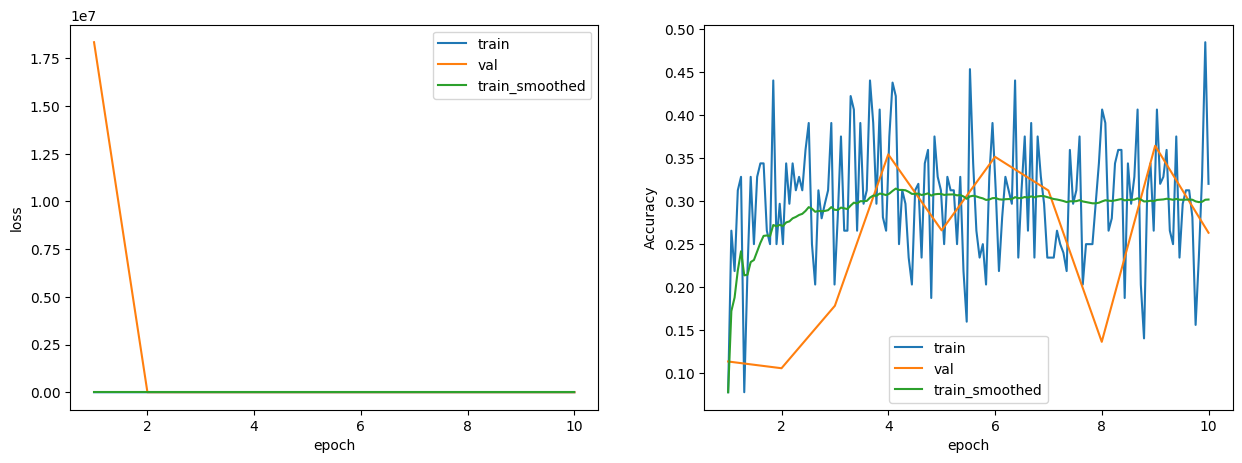

In [ ]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [ ]:
test(resnet_model, test_loader)

(2.205345392227173, 0.60521399974823, 0.60521399974823)

In [5]:
torch.save(resnet_model.state_dict(), 'models/resnet.pt')

In [ ]:
from torchvision.models import densenet121
densenet_model = densenet121(weights=None)
densenet_model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 5)
densenet_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 500
optimizer = optim.SGD(densenet_model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
densenet_model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(densenet_model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/500 [00:00<?, ?it/s]

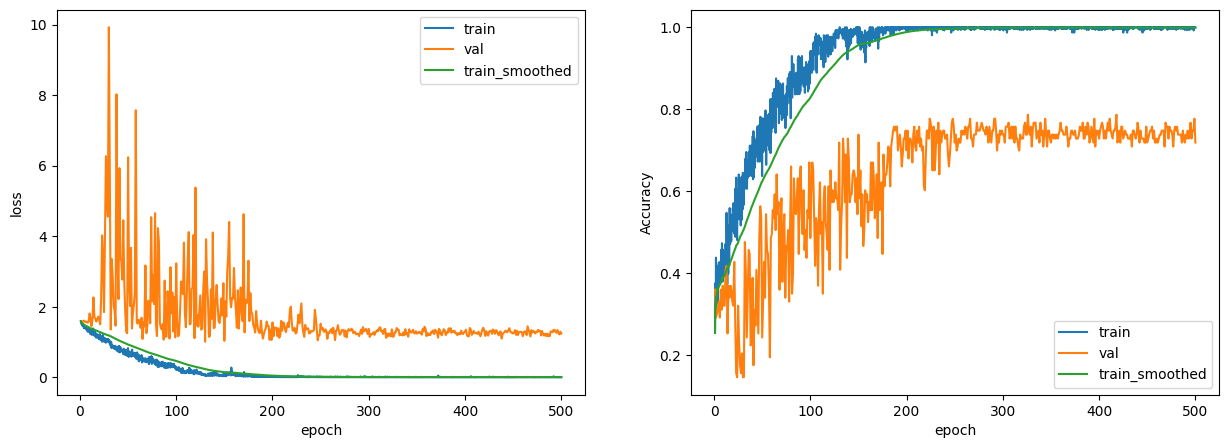

In [ ]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [ ]:
test(densenet_model, test_loader)

(0.9618663787841797, 0.765964686870575, 0.765964686870575)

In [ ]:
torch.save(densenet_model.state_dict(), 'models/densnet121_1.pt')

In [ ]:
densnet121_model = densenet121(weights=None)
densnet121_model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densnet121_model.classifier = nn.Linear(densnet121_model.classifier.in_features, 5)
epochs = 500
optimizer = optim.SGD(densnet121_model.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
densnet121_model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(densnet121_model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/500 [00:00<?, ?it/s]

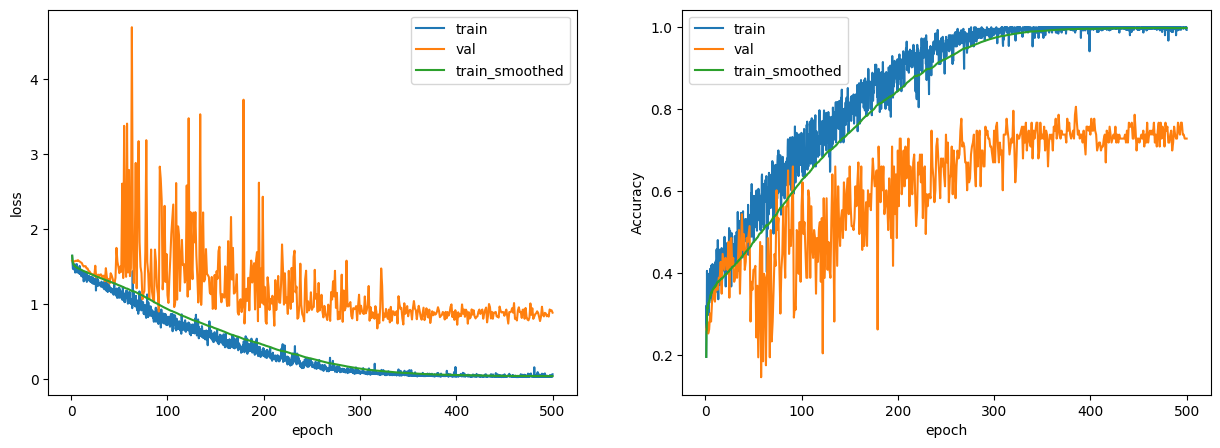

In [ ]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

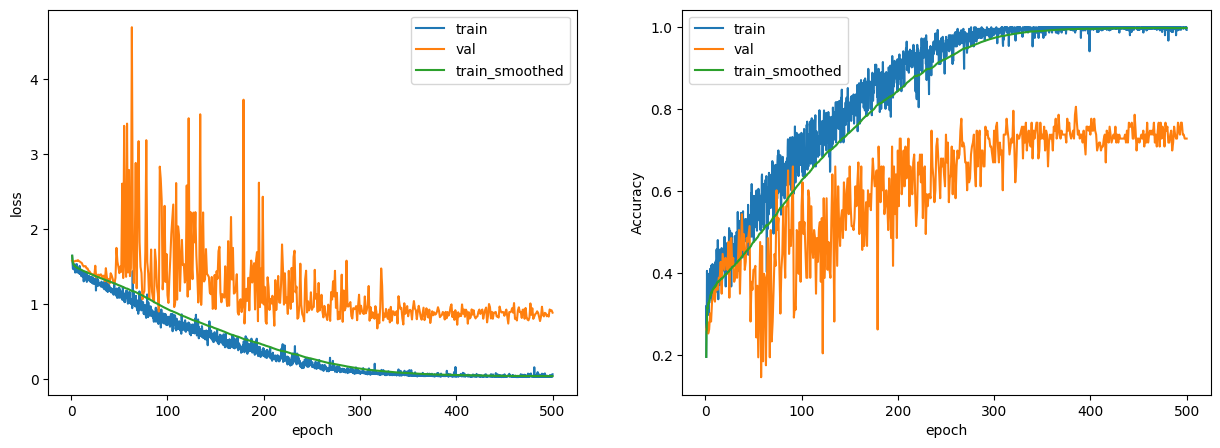

In [ ]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [ ]:
test(densnet121_model, test_loader)

(0.7039664089679718, 0.7909307181835175, 0.7909307181835175)

In [ ]:
torch.save(densnet121_model.state_dict(), 'models/densnet121.pt')

In [ ]:
from torchvision.models import efficientnet_v2_s
efficientnet_v2_s_model = efficientnet_v2_s(weights=None)
efficientnet_v2_s_model.features[0][0] = nn.Conv2d(1, efficientnet_v2_s_model.features[0][0].out_channels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
efficientnet_v2_s_model.classifier[1] = nn.Linear(efficientnet_v2_s_model.classifier[1].in_features, 5)
efficientnet_v2_s_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
epochs = 500
optimizer = optim.SGD(efficientnet_v2_s_model.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.0001,)
efficientnet_v2_s_model.to(device)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(efficientnet_v2_s_model, optimizer, epochs, train_loader, val_loader, scheduler)

  0%|          | 0/500 [00:00<?, ?it/s]

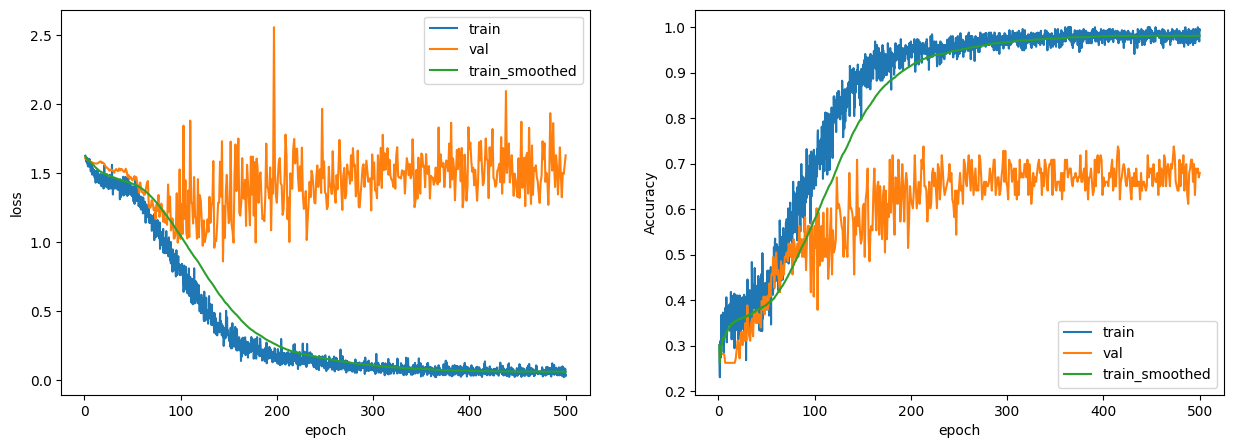

In [ ]:
plot_losses(tr_loss_log, tr_acc_log, val_loss_log, val_acc_log)

In [ ]:
test(efficientnet_v2_s_model, test_loader)

(1.58674818277359, 0.6845278739929199, 0.6845278441905975)

In [ ]:
torch.save(efficientnet_v2_s_model.state_dict(), 'models/efficientnet_v2_s.pt')

In [3]:
from ultralytics import YOLO

yolo_model = YOLO("/content/drive/MyDrive/Project_hse/yolov8n-cls.pt")

res = yolo_model.train(data= "/content/drive/MyDrive/Project_hse/data_yolo", epochs= 70, batch= 32, device= 0, imgsz= 300, plots= True)
metrics = yolo_model.val()

Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/Project_hse/yolov8n-cls.pt, data=/content/drive/MyDrive/Project_hse/data_yolo, epochs=70, time=None, patience=100, batch=32, imgsz=300, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

100%|██████████| 6.23M/6.23M [00:00<00:00, 303MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
WARNING ⚠️ imgsz=[300] must be multiple of max stride 32, updating to [320]


train: Scanning /content/drive/MyDrive/Project_hse/data_yolo/train... 1314 images, 0 corrupt: 100%|██████████| 1314/1314 [11:23<00:00,  1.92it/s]


train: New cache created: /content/drive/MyDrive/Project_hse/data_yolo/train.cache


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Project_hse/data_yolo/val... 50 images, 0 corrupt: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s]

val: New cache created: /content/drive/MyDrive/Project_hse/data_yolo/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 70 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/70     0.952G      1.611         32        320:  24%|██▍       | 10/42 [00:04<00:14,  2.24it/s]

       1/70     0.952G      1.585         32        320:  40%|████      | 17/42 [00:07<00:11,  2.21it/s]
100%|██████████| 755k/755k [00:00<00:00, 96.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all       0.26          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]

                   all       0.66          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 26.05it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.62it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]

                   all       0.64          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 30.18it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      10/70     0.818G     0.5882          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      11/70     0.818G     0.5612          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


      12/70     0.818G     0.5187          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.57it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      13/70     0.818G     0.4688          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      14/70     0.818G     0.4736          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      15/70     0.818G     0.4341          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s]

                   all       0.88          1



      Epoch    GPU_mem       loss  Instances       Size


      16/70     0.818G     0.4403          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 28.75it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      17/70     0.818G     0.4073          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      18/70     0.818G     0.4091          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.58it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      19/70     0.818G      0.376          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      20/70     0.818G      0.384          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      21/70     0.818G     0.3364          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 36.05it/s]

                   all       0.88          1



      Epoch    GPU_mem       loss  Instances       Size


      22/70     0.818G     0.3332          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


      23/70     0.818G     0.3128          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 26.43it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      24/70     0.818G     0.3184          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      25/70     0.818G     0.3029          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


      26/70     0.818G     0.2785          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      27/70     0.818G     0.2483          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      28/70     0.818G     0.2569          2        320: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      29/70     0.818G     0.2493          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


      30/70     0.818G     0.2504          2        320: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      31/70     0.818G      0.274          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      32/70     0.818G     0.3176          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      33/70     0.818G     0.2557          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 42.45it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      34/70     0.818G      0.194          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      35/70     0.818G      0.318          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      36/70     0.818G     0.2204          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      37/70     0.818G     0.1903          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      38/70     0.818G     0.2299          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

                   all       0.84          1



      Epoch    GPU_mem       loss  Instances       Size


      39/70     0.818G     0.2686          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      40/70     0.818G     0.1697          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.98it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      41/70     0.818G     0.2716          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


      42/70     0.818G     0.2207          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 34.55it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      43/70     0.818G     0.1962          2        320: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      44/70     0.818G     0.2278          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


      45/70     0.818G     0.2263          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      46/70     0.818G     0.1505          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]

                   all       0.72          1



      Epoch    GPU_mem       loss  Instances       Size


      47/70     0.818G      0.162          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      48/70     0.818G     0.1901          2        320: 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 36.82it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      49/70     0.818G     0.1445          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s]

                   all       0.72          1



      Epoch    GPU_mem       loss  Instances       Size


      50/70     0.818G     0.1508          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      51/70     0.818G     0.1349          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 33.50it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      52/70     0.818G     0.1451          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      53/70     0.818G     0.1765          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      54/70     0.818G     0.1762          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      55/70     0.818G     0.2013          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      56/70     0.818G     0.2053          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 27.59it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      57/70     0.818G     0.1416          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.23it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      58/70     0.818G     0.2005          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 30.35it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      59/70     0.818G     0.1789          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      60/70     0.818G     0.1295          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s]

                   all       0.78          1



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      61/70     0.818G     0.1988          2        320: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      62/70     0.818G     0.1263          2        320: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      63/70     0.818G      0.118          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 36.20it/s]

                   all       0.76          1



      Epoch    GPU_mem       loss  Instances       Size


      64/70     0.818G     0.1254          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.76it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      65/70     0.818G     0.1777          2        320: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


                   all        0.8          1

      Epoch    GPU_mem       loss  Instances       Size


      66/70     0.818G     0.1155          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      67/70     0.818G     0.1209          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s]

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      68/70     0.818G     0.1106          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      69/70     0.818G     0.2328          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      70/70     0.818G     0.1313          2        320: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]

                   all        0.8          1



70 epochs completed in 0.418 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1441285 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/Project_hse/data_yolo/train... found 1314 images in 5 classes ✅ 
val: /content/drive/MyDrive/Project_hse/data_yolo/val... found 50 images in 5 classes ✅ 
test: /content/drive/MyDrive/Project_hse/data_yolo/test... found 100 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


                   all        0.9          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train
Ultralytics YOLOv8.2.27 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1441285 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/Project_hse/data_yolo/train... found 1314 images in 5 classes ✅ 
val: /content/drive/MyDrive/Project_hse/data_yolo/val... found 50 images in 5 classes ✅ 
test: /content/drive/MyDrive/Project_hse/data_yolo/test... found 100 images in 5 classes ✅ 


val: Scanning /content/drive/MyDrive/Project_hse/data_yolo/val... 50 images, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


                   all       0.88          1
Speed: 0.1ms preprocess, 6.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [4]:
metrics

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6ca8332530>
curves: []
curves_results: []
fitness: 0.9399999976158142
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8799999952316284, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9399999976158142}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.12174606323242188, 'inference': 6.12574577331543, 'loss': 0.0007867813110351562, 'postprocess': 0.0016641616821289062}
task: 'classify'
top1: 0.8799999952316284
top5: 1.0